/home/gupta/anaconda3/envs/vit-env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Loading models...


/home/gupta/anaconda3/envs/vit-env/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/gupta/anaconda3/envs/vit-env/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Processing:   0%|          | 0/3000 [00:00<?, ?it/s]


=== Running for ResNet-50 ===
== Top-5 Before Attack ==
1: Class 155 (Shih-Tzu), Confidence: 0.7359
2: Class 187 (Yorkshire terrier), Confidence: 0.2194
3: Class 193 (Australian terrier), Confidence: 0.0036
4: Class 201 (silky terrier), Confidence: 0.0034
5: Class 265 (toy poodle), Confidence: 0.0026


Attacking:   1%|          | 119/10000 [00:10<14:45, 11.15it/s, 187=0.4804, 155=0.4591, 193=0.0056]


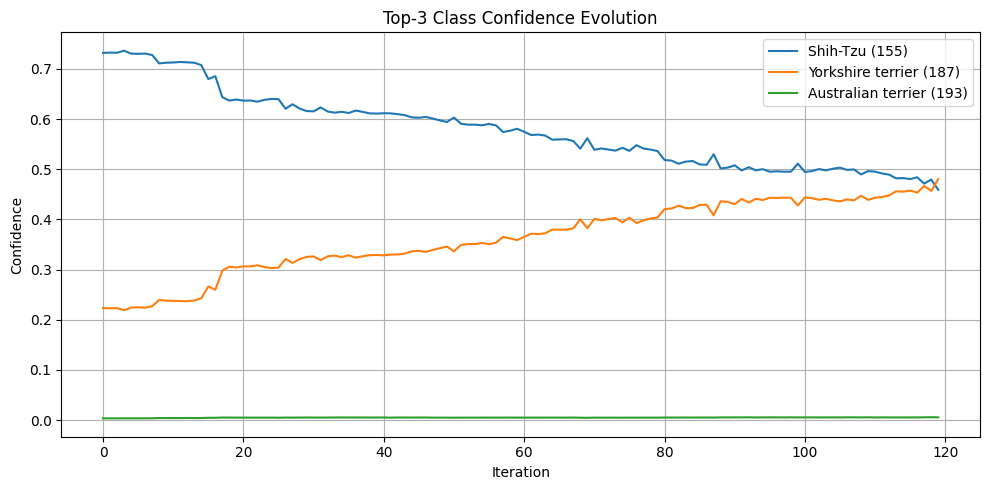

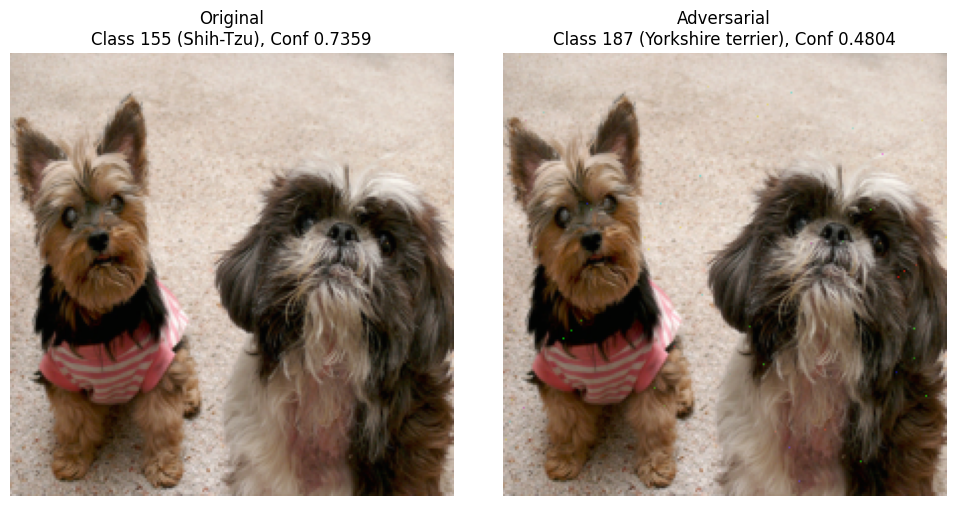

Processing:   0%|          | 1/3000 [00:11<9:11:35, 11.04s/it]


=== Running for VGG16 ===
== Top-5 Before Attack ==
1: Class 187 (Yorkshire terrier), Confidence: 0.5824
2: Class 155 (Shih-Tzu), Confidence: 0.2244
3: Class 252 (affenpinscher), Confidence: 0.0806
4: Class 262 (Brabancon griffon), Confidence: 0.0377
5: Class 201 (silky terrier), Confidence: 0.0205


Attacking:   2%|▏         | 194/10000 [00:40<34:01,  4.80it/s, 155=0.4053, 187=0.4048, 252=0.0744]


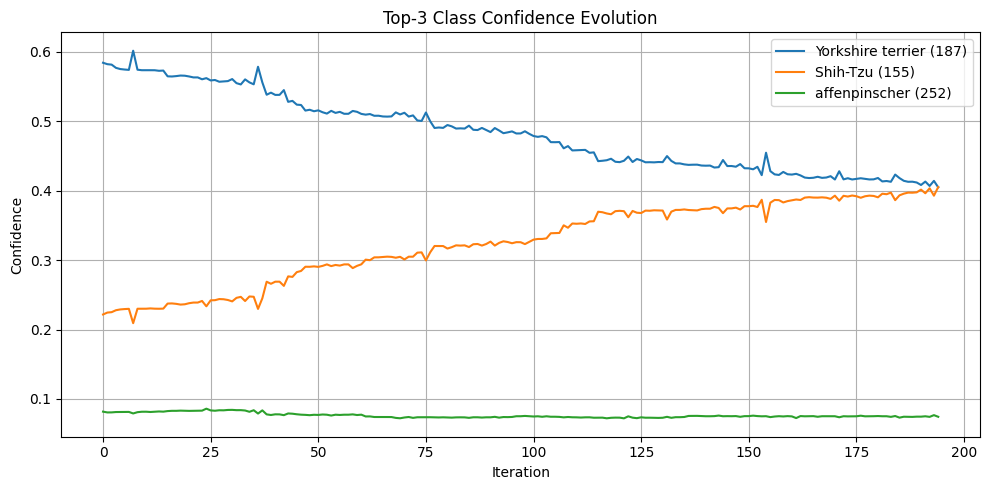

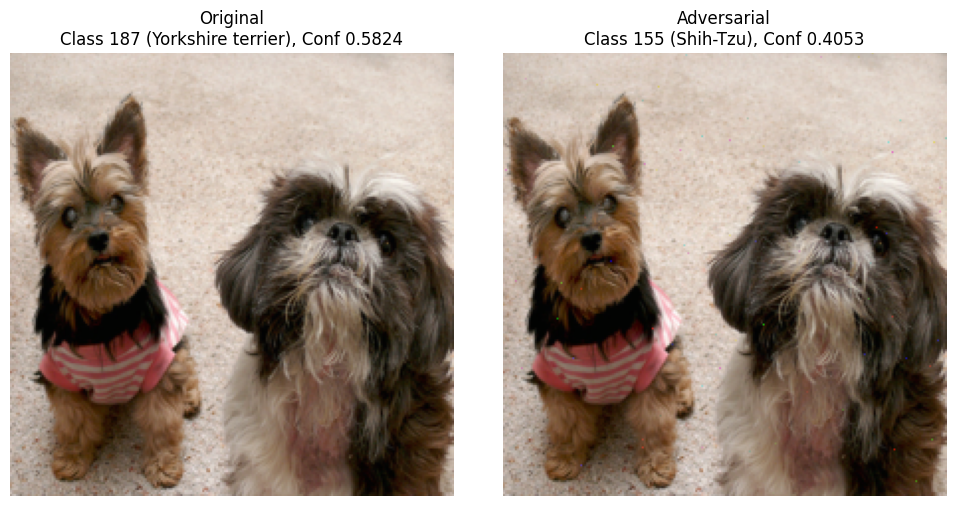

Processing:   0%|          | 2/3000 [00:51<23:46:10, 28.54s/it]


=== Running for ViT-B/16 ===
== Top-5 Before Attack ==
1: Class 187 (Yorkshire terrier), Confidence: 0.7704
2: Class 155 (Shih-Tzu), Confidence: 0.0805
3: Class 193 (Australian terrier), Confidence: 0.0402
4: Class 196 (miniature schnauzer), Confidence: 0.0141
5: Class 204 (Lhasa), Confidence: 0.0125


Attacking:   3%|▎         | 348/10000 [01:49<50:47,  3.17it/s, 187=0.5224, 155=0.2279, 204=0.0435]


KeyboardInterrupt: 

In [1]:
import os
import random
import torch
import torch.nn.functional as F
import torchvision.transforms as T
from torchvision import models as tv_models
from PIL import Image, UnidentifiedImageError
import timm
from tqdm import tqdm
import urllib.request
import pandas as pd
import matplotlib.pyplot as plt

# === CONFIG ===
IMAGE_FOLDER = 'ILSVRC2012_img_val'
SAMPLE_SIZE = 1000
MAX_ITER = 10000
CSV_LOG = 'attack_log.csv'

MODEL_CONFIGS = [
    ('ResNet-50', lambda: timm.create_model('resnet50', pretrained=True)),
    ('VGG16', lambda: tv_models.vgg16(pretrained=True)),
    ('ViT-B/16', lambda: timm.create_model('vit_base_patch16_224', pretrained=True))
]

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# === LOAD IMAGENET CLASS LABELS ===
url = "https://raw.githubusercontent.com/pytorch/hub/master/imagenet_classes.txt"
imagenet_classes = urllib.request.urlopen(url).read().decode("utf-8").splitlines()

# === IMAGE TRANSFORM ===
transform = T.Compose([
    T.Resize((224, 224)),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225])
])

# === ONE-PIXEL ATTACK WITH LIVE TQDM AND LOGGING ===
def one_pixel_attack_until_flipped(img_tensor, target_idx, model, max_iter=1000):
    img = img_tensor.clone().detach()
    _, c, h, w = img.shape
    class_conf_log = {}
    pbar = tqdm(range(max_iter), desc="Attacking", dynamic_ncols=True)
    for i in pbar:
        candidate = img.clone()
        x, y = random.randint(0, w - 1), random.randint(0, h - 1)
        ch = random.randint(0, 2)
        candidate[0, ch, y, x] = torch.rand(1).item()

        with torch.no_grad():
            probs = F.softmax(model(candidate), dim=1)
            top_probs, top_idxs = probs.topk(3)
            top_probs = top_probs.squeeze(0)
            top_idxs = top_idxs.squeeze(0)

        # Log confidence evolution
        for idx, prob in zip(top_idxs.tolist(), top_probs.tolist()):
            if idx not in class_conf_log:
                class_conf_log[idx] = []
            class_conf_log[idx].append((i, prob))

        stats = {
            f"{top_idxs[0].item()}": f"{top_probs[0].item():.4f}",
            f"{top_idxs[1].item()}": f"{top_probs[1].item():.4f}",
            f"{top_idxs[2].item()}": f"{top_probs[2].item():.4f}"
        }
        pbar.set_postfix(stats)

        if top_idxs[0].item() != target_idx:
            return candidate, top_idxs.tolist(), top_probs.tolist(), True, class_conf_log

        orig_conf = F.softmax(model(img), dim=1)[0, target_idx]
        new_conf = probs[0, target_idx]
        if new_conf < orig_conf:
            img = candidate

    final_probs, final_idxs = F.softmax(model(img), dim=1).topk(3)
    return img, final_idxs.squeeze(0).tolist(), final_probs.squeeze(0).tolist(), False, class_conf_log

# === GET TOP-K PREDICTIONS ===
def get_topk(model, img_tensor, k=5):
    with torch.no_grad():
        output = model(img_tensor)
        probs = F.softmax(output, dim=1)
        topk_probs, topk_idxs = probs.topk(k)
    return topk_probs.squeeze(0).tolist(), topk_idxs.squeeze(0).tolist()

# === PLOT CONFIDENCE TRACKING ===
def plot_confidence_log(log):
    plt.figure(figsize=(10, 5))
    for class_id, entries in log.items():
        steps, confs = zip(*entries)
        label = f"{imagenet_classes[class_id]} ({class_id})"
        plt.plot(steps, confs, label=label)
    plt.xlabel("Iteration")
    plt.ylabel("Confidence")
    plt.title("Top-3 Class Confidence Evolution")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# === IMAGE VISUALIZATION ===
def show_images_with_titles(original, adversarial, orig_class, orig_conf, adv_class, adv_conf):
    to_pil = T.ToPILImage()
    unnormalize = T.Normalize(
        mean=[-m / s for m, s in zip([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])],
        std=[1 / s for s in [0.229, 0.224, 0.225]]
    )
    orig_img = to_pil(unnormalize(original.squeeze().cpu()))
    adv_img = to_pil(unnormalize(adversarial.squeeze().cpu()))
    fig, axs = plt.subplots(1, 2, figsize=(10, 5))

    axs[0].imshow(orig_img)
    axs[0].set_title(f"Original\nClass {orig_class} ({imagenet_classes[orig_class]}), Conf {orig_conf:.4f}")
    axs[0].axis('off')

    axs[1].imshow(adv_img)
    axs[1].set_title(f"Adversarial\nClass {adv_class} ({imagenet_classes[adv_class]}), Conf {adv_conf:.4f}")
    axs[1].axis('off')

    plt.tight_layout()
    plt.show()

# === LOAD MODELS ONCE ===
print("Loading models...")
loaded_models = {}
for model_name, model_fn in MODEL_CONFIGS:
    model = model_fn().to(device)
    model.eval()
    loaded_models[model_name] = model

# === SELECT RANDOM IMAGES ===
image_paths = [os.path.join(IMAGE_FOLDER, f) for f in os.listdir(IMAGE_FOLDER)
               if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
random.shuffle(image_paths)
image_paths = image_paths[:SAMPLE_SIZE]

log_rows = []

# === MAIN LOOP ===
outer_pbar = tqdm(total=len(image_paths) * len(loaded_models), desc="Processing", dynamic_ncols=True)

for img_path in image_paths:
    try:
        image = Image.open(img_path).convert('RGB')
        img_tensor = transform(image).unsqueeze(0).to(device)
    except (UnidentifiedImageError, OSError):
        continue

    for model_name, model in loaded_models.items():
        try:
            print(f"\n=== Running for {model_name} ===")
            orig_probs, orig_idxs = get_topk(model, img_tensor, k=5)
            print("== Top-5 Before Attack ==")
            for i, (idx, prob) in enumerate(zip(orig_idxs, orig_probs)):
                print(f"{i+1}: Class {idx} ({imagenet_classes[idx]}), Confidence: {prob:.4f}")

            orig_top1_idx = orig_idxs[0]
            orig_top1_label = imagenet_classes[orig_top1_idx]
            orig_top1_conf = orig_probs[0]

            adv_tensor, adv_idxs, adv_probs, flipped, class_log = one_pixel_attack_until_flipped(
                img_tensor, target_idx=orig_top1_idx, model=model, max_iter=MAX_ITER)

            # Plot confidence evolution
            plot_confidence_log(class_log)

            # Visualize images
            show_images_with_titles(
                img_tensor, adv_tensor,
                orig_class=orig_top1_idx,
                orig_conf=orig_top1_conf,
                adv_class=adv_idxs[0],
                adv_conf=adv_probs[0]
            )

            # Save results
            row = {
                'image_path': img_path,
                'model': model_name,
                'orig_class_idx': orig_top1_idx,
                'orig_class_label': orig_top1_label,
                'orig_confidence': orig_top1_conf,
                'adv_class_idx': adv_idxs[0],
                'adv_class_label': imagenet_classes[adv_idxs[0]],
                'adv_confidence': adv_probs[0],
                'flipped': flipped,
                'adv_top2_idx': adv_idxs[1],
                'adv_top2_label': imagenet_classes[adv_idxs[1]],
                'adv_top2_conf': adv_probs[1],
                'adv_top3_idx': adv_idxs[2],
                'adv_top3_label': imagenet_classes[adv_idxs[2]],
                'adv_top3_conf': adv_probs[2]
            }
            log_rows.append(row)
        except Exception:
            continue

        outer_pbar.update(1)

outer_pbar.close()

# === SAVE LOG TO CSV ===
df = pd.DataFrame(log_rows)
df.to_csv(CSV_LOG, index=False)
print(f"\n✅ Attack log saved to {CSV_LOG}")
